# Mixtures
The goal of this notebook is to examine mixtures of outputs from nucleosynthetic processes.

Begin by installing and importing the necessary python libraries

In [1]:
import sys, io, requests
from ipywidgets import interact, interactive
import ipywidgets as widgets

!{sys.executable} -m pip install --quiet wnutils
!{sys.executable} -m pip install --quiet matplotlib

import matplotlib.pyplot as plt
import wnutils.xml as wx 
import numpy as np
from scipy.optimize import curve_fit

# Preliminaries.

Define a routine to retrieve zone abundances from the xml data.

In [2]:
def get_zone_abunds(my_xml):
    zones = my_xml.get_zone_data()
    proc = {}
    for key in zones:
        proc[key] = {}
        for tup in zones[key]['mass fractions']:
            proc[key][tup[0]] = zones[key]['mass fractions'][tup] / tup[2]
    return proc

Define a routine to retrieve the data for the processes and store in arrays.

In [3]:
def get_proc(sp, norm_species):

    y = []

    proc = {}
    for key in result:
        proc[key] = np.zeros(len(sp))
        count = 0
        for s in sp:
            if s in result[key]:
                proc[key][count] = result[key][s]
            count += 1
            
    for key in result:
        proc[key] /= (np.sum(proc[key]) + 1.e-300) # Add a small amount to denominator in case contribution is zero.
    
    return proc

# Study nucleosynthesis mixtures.

Begin by reading in network data from [OSF](https://osf.io/kjnct/).  Retrieve the nuclides.

In [4]:
xml = wx.Xml(io.BytesIO(requests.get('https://osf.io/kyhbs/download').content))
nucs = xml.get_nuclide_data()

Next, read in the nucleosynthesis processes data and store in a wnutils XML object.  The default is to use files downloaded from [OSF](https://osf.io/mrgbp/).  To use your own data, put them in your working directory or uploading to Colab or Binder.  Then uncomment the second line and replace *example.xml* with the chosen name.

In [5]:
rsp = wx.Xml(io.BytesIO(requests.get('https://osf.io/5ztd7/download').content))
#wx.Xml('example.xml')

Retrieve the data for the processes.

In [6]:
result = get_zone_abunds(rsp)

Specify the species of interest and the normalizing species.

In [7]:
sp = np.array(['mo92', 'mo94', 'mo95', 'mo96', 'mo97', 'mo98', 'mo100'])
norm_species = 'mo96'

element_string = ""
for char in norm_species:
    if char.isalpha():
        element_string += char
        
element_string = element_string.capitalize()

a = np.empty([0])
for species in sp:
    a = np.append(a, nucs[species]['a'])
    
sp_string = '^{i}\\rm{' + element_string + '} / ' + xml.get_latex_names(sp)[norm_species].strip('$')

Get the process data for the species.  Set the normalization index and mass-fractionation correction species index.  The commented command shows a "hack" to include a small contribution of the p-process to the weak s-process component of mo94.

In [8]:
proc = get_proc(sp, norm_species)
i_norm = np.where(sp == norm_species)

#proc['ws'][1] = 0.05 * proc['p'][1]

Plot the process contributions.

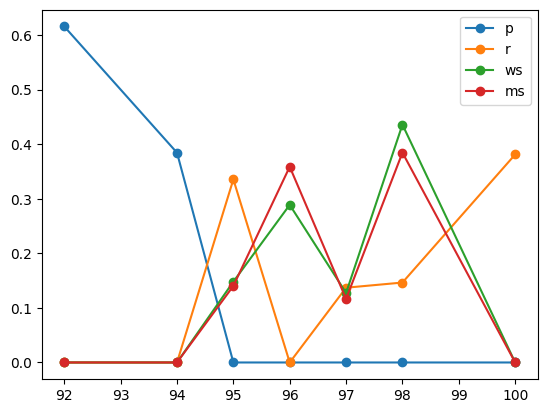

In [9]:
for key in proc:
    plt.plot(a, proc[key], 'o-', label = key)
    
plt.legend()

Input the standard abundance ratios.  Here we use [Anders and Grevesse (1989)](https://osf.io/udvsk/).

In [10]:
solar = wx.Xml(io.BytesIO(requests.get('https://osf.io/w8ktc/download').content))

y = {}
mass_fractions = solar.get_zone_data()['0']['mass fractions']
for tup in mass_fractions:
    y[tup[0]] = mass_fractions[tup] / tup[2]
    
standard = []

for s in sp:
    standard = np.append(standard, y[s] / y[norm_species])

Define a fit function for the processes to the standard abundances.

In [11]:
def fit_function(x, a_p, a_r, a_ms, a_ws):
    result = a_p * proc['p'] + a_r * proc['r'] + a_ms * proc['ms'] + a_ws * proc['ws']
    result /= result[i_norm]
    return result

Compute the best fit to the standard.  Normalize the fit parameters.

In [12]:
popt_std, pcov_std = curve_fit(fit_function, a, standard, bounds=(0, [1, 1, 1, 1]))
popt_std /= np.sum(popt_std)

Plot the fit.

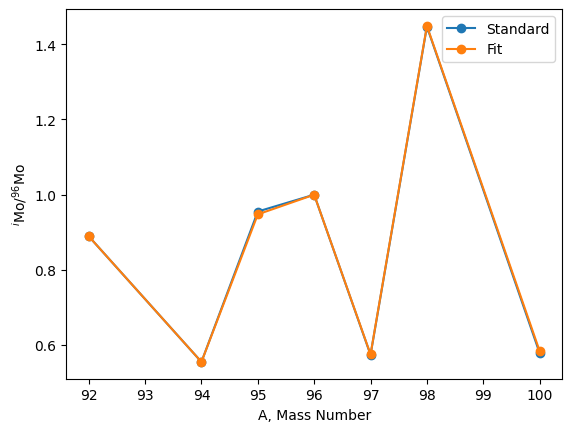

In [13]:
plt.plot(a, standard, '-o', label='Standard')

plt.plot(a, fit_function(a, *popt_std), '-o', label='Fit')

plt.xlabel('A, Mass Number')
plt.ylabel('$' + sp_string + '$')
plt.legend()

With the fit of nucleosynthetic components available, compute and print out the process contributions for each species.  The number in parentheses gives the abundance of the species relative to the normalizing speices in the fit.

In [14]:
c_hash = {'p': 0, 'r': 1, 'ms': 2, 'ws': 3}

y_fit = {}
y_sum = np.zeros(len(a))
for key in c_hash:
    y_fit[key] = popt_std[c_hash[key]] * proc[key]
    y_sum += y_fit[key]
    
contribs = {}
    
for key in y_fit:
    contribs[key] = 100. * y_fit[key] / y_sum 
    
for i in range(len(sp)):
    print('{:s} ({:.2f}% of {:s})'.format(sp[i], 100 * y_sum[i] / np.sum(y_sum), element_string))
    for key in contribs:
        print('    {:s}: {:.2f}%'.format(key, contribs[key][i]))
    print("")

mo92 (14.82% of Mo)
    p: 100.00%
    r: 0.00%
    ms: 0.00%
    ws: 0.00%

mo94 (9.25% of Mo)
    p: 100.00%
    r: 0.00%
    ms: 0.00%
    ws: 0.00%

mo95 (15.79% of Mo)
    p: 0.00%
    r: 54.27%
    ms: 26.90%
    ws: 18.83%

mo96 (16.66% of Mo)
    p: 0.00%
    r: 0.00%
    ms: 65.19%
    ws: 34.81%

mo97 (9.59% of Mo)
    p: 0.00%
    r: 36.51%
    ms: 36.81%
    ws: 26.68%

mo98 (24.14% of Mo)
    p: 0.00%
    r: 15.50%
    ms: 48.24%
    ws: 36.26%

mo100 (9.74% of Mo)
    p: 0.00%
    r: 100.00%
    ms: 0.00%
    ws: 0.00%



Now graphically represent the process contributions to each species.

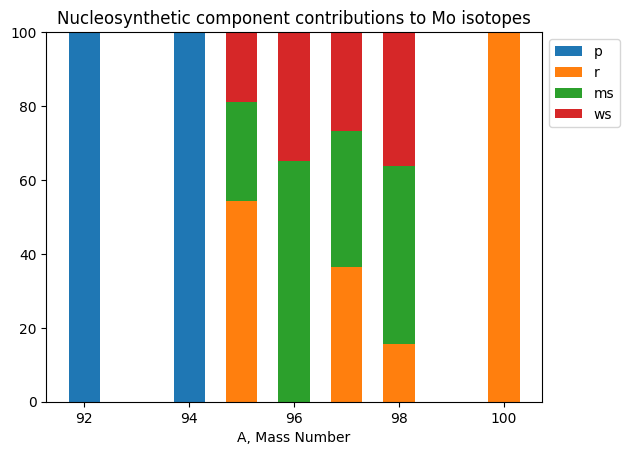

In [15]:
width = 0.6

fig, ax = plt.subplots()
bottom = np.zeros(len(a))

for key, contrib in contribs.items():
    p = ax.bar(a, contrib, width, label=key, bottom=bottom)
    bottom += contrib

    #ax.bar_label(p, label_type='center', fmt="%.0f")
    
ax.set_xlabel('A, Mass Number')
    
ax.set_title('Nucleosynthetic component contributions to {:s} isotopes'.format(element_string))
ax.legend(bbox_to_anchor = (1,1), loc='upper left', ncol = 1)

plt.show()

With appropriate nucleosynthetic contributions now available, you can practice adding and subtracting different mixes of those components (in parts per million). Set rng to define the range of variation of the components and step to define the increment size. Use the slider bars to adjust the contribution of each component away from the fit to the standard. You can click on a slider and move it, or, once you have clicked on the button, use the left and right arrows on your key board to increase or decrease the contribution. Note that p_proc is the p-process component, r_proc is the r-process component, ms_proc is the main s-process component, and ws_proc is the weak s-process component.

In [16]:
rng = 1000
step = 1

def f(p_proc, r_proc, ms_proc, ws_proc):
    c_p = (1 + p_proc/1.e6) * popt_std[0]
    c_r = (1 + r_proc/1.e6) * popt_std[1]
    c_ms = (1 + ms_proc/1.e6) * popt_std[2]
    c_ws = (1 + ws_proc/1.e6) * popt_std[3]

    reference = fit_function(a, *popt_std)
    reference /= reference[i_norm]
    result = c_p * proc['p'] + c_r * proc['r'] + c_ms * proc['ms'] + c_ws * proc['ws']
    result /= result[i_norm]
    mu = 1.e6 * (result / reference - 1)
        
    plt.plot(a, mu, '-o', label='fit')

    plt.xlabel('A, Mass Number')
    plt.ylabel('$\\mu(' + sp_string + ')$')
        
    plt.show()
        
interact(f, p_proc=(-rng,rng,step), r_proc=(-rng,rng,step), ms_proc=(-rng,rng,step), ws_proc=(-rng,rng,step))

interactive(children=(IntSlider(value=0, description='p_proc', max=1000, min=-1000), IntSlider(value=0, descri…

<function __main__.f(p_proc, r_proc, ms_proc, ws_proc)>

# Compare to data.

This section allows the user to compare nucleosynthetic mixtures to data.  The default is not to run the comparison, as the following cell sets empty arrays for the data and error values.

In [17]:
data = []
error = []

Add data, if desired.  The *data* array shows the deviations from the standard for each species (in parts per million) while *error* is the array giving the uncertainty for each data point.  The *data* and *error* arrays need to match up with the *a* and *sp* arrays defined above.

To compare to data, uncomment the three lines of the cell, replace the *correction_species* and data and error arrays with your own values, and run the following cells.  Make sure that no error value is zero as this will cause a problem with the fits.

In [18]:
#correction_species = 'mo98'
#data = np.array([-54.1, -26.1, -3.4, 0., 11.3, 0., -40.9])
#error = np.array([34.0, 10.1, 3.9, 0.1, 2.5, 0.1, 9.5])

Check for zero error values.

In [19]:
if len(data) > 0:
    assert np.all(error), "An error value is zero."

Define a fit function for the anomaly data.

In [20]:
if len(data) > 0:
    def fit_function2(x, a_p, a_r, a_ms, a_ws):
        result = a_p * proc['p'] + a_r * proc['r'] + a_ms * proc['ms'] + a_ws * proc['ws']
        result /= result[i_norm]    
        reference = fit_function(x, *popt_std)
        mu = 1.e6 * ((result / reference) - 1)
        return mu

Fit the data.  Normalize the fit parameters.

In [21]:
if len(data) > 0:
    popt_mu, pcov_mu = curve_fit(fit_function2, a, data, bounds=(0, [1, 1, 1, 1]), sigma=error)
    popt_mu /= np.sum(popt_mu)

Print the fit parameters.

In [22]:
if len(data) > 0:
    a_fit = 1.e6 * (popt_mu/np.sum(popt_mu)/(popt_std/np.sum(popt_std)) - 1)

    print('p_proc: {:.2f}'.format(a_fit[0]))
    print('r_proc: {:.2f}'.format(a_fit[1]))
    print('ms_proc: {:.2f}'.format(a_fit[2]))
    print('ws_proc: {:.2f}'.format(a_fit[3]))

Add and subtract nucleosynthetic components (in parts per million) to fit the data. Use the slider bars to adjust the contribution of each component. You can click on a slider and move it, or, once you have clicked on the button, use the left and right arrows on your key board to increase or decrease the contributiom. Note that p_proc is the p-process component, r_proc is the r-process component, ms_proc is the main s-process component, and ws_proc is the weak s-process component.

The plot starts with the best fit parameters from the cell above.

In [23]:
if len(data) > 0:
    def f(p_proc, r_proc, ms_proc, ws_proc):
        c_p = (1 + p_proc/1.e6) * popt_std[0]
        c_r = (1 + r_proc/1.e6) * popt_std[1]
        c_ms = (1 + ms_proc/1.e6) * popt_std[2]
        c_ws = (1 + ws_proc/1.e6) * popt_std[3]

        reference = fit_function(a, *popt_std)
        reference /= reference[i_norm]
        result = c_p * proc['p'] + c_r * proc['r'] + c_ms * proc['ms'] + c_ws * proc['ws']
        result /= result[i_norm]
        mu = 1.e6 * (result / reference - 1)
    
        plt.plot(a, mu, '-o', label='fit')
        plt.errorbar(a, data, fmt='-o', yerr=error, label='data')

        plt.xlabel('A, Mass Number')
        plt.ylabel('$\\mu(' + sp_string + ')$')
        plt.legend()
        
        plt.show()
        
    interact(f, p_proc=a_fit[0], r_proc=a_fit[1], ms_proc=a_fit[2], ws_proc=a_fit[3])